<a href="https://colab.research.google.com/github/Srimugdha04/codealphaprojects/blob/main/Multi-domain%20customer%20churn%20prediction(telecom-bank%20datasets).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
telecom = pd.read_csv("/content/drive/MyDrive/telecom dataset.csv")
bank = pd.read_csv("/content/drive/MyDrive/bank dataset.csv")
mapping = pd.read_csv("/content/drive/MyDrive/BankFeature-TelecomFeature-Comment.csv")

In [3]:
telecom['Churn'] = telecom['Churn'].astype(int)
bank.rename(columns={'Exited':'Churn'}, inplace=True)


In [15]:
telecom_features = [
    'Account length',
    'Total day charge',
    'Customer service calls',
    'International plan',
    'Voice mail plan',
    'Total day minutes',
    'Total intl calls'
]

bank_features = [
    'Tenure',
    'Balance',
    'Complain',
    'HasCrCard',
    'IsActiveMember',
    'EstimatedSalary',
    'NumOfProducts'
]

X_telecom = telecom[telecom_features].copy()
X_bank = bank[bank_features].copy()

y_telecom = telecom['Churn']
y_bank = bank['Churn']

# Rename bank columns to match telecom
X_bank.columns = X_telecom.columns


In [16]:
from sklearn.preprocessing import LabelEncoder

for col in X_telecom.select_dtypes(include='object'):
    le = LabelEncoder()
    X_telecom[col] = le.fit_transform(X_telecom[col])

for col in X_bank.select_dtypes(include='object'):
    le = LabelEncoder()
    X_bank[col] = le.fit_transform(X_bank[col])


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_telecom = scaler.fit_transform(X_telecom)
X_bank = scaler.transform(X_bank)


In [18]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bank, y_bank,
    test_size=0.2,
    stratify=y_bank,
    random_state=42
)


In [19]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(yb_train),
    y=yb_train
)

class_weights = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.6279434850863422), 1: np.float64(2.4539877300613497)}


In [20]:
baseline_input = Input(shape=(Xb_train.shape[1],))
x = Dense(32, activation='relu')(baseline_input)
x = Dense(16, activation='relu')(x)
baseline_output = Dense(1, activation='sigmoid')(x)

baseline = Model(inputs=baseline_input, outputs=baseline_output)

baseline.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

baseline.fit(
    Xb_train, yb_train,
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    verbose=0
)

# Evaluate Baseline
y_prob_base = baseline.predict(Xb_test)
y_pred_base = (y_prob_base > 0.5).astype(int)

print("\n=== Baseline Report ===")
print(classification_report(yb_test, y_pred_base))
print("Baseline AUC:", roc_auc_score(yb_test, y_prob_base))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== Baseline Report ===
              precision    recall  f1-score   support

           0       0.88      0.42      0.57      1592
           1       0.26      0.78      0.39       408

    accuracy                           0.49      2000
   macro avg       0.57      0.60      0.48      2000
weighted avg       0.75      0.49      0.53      2000

Baseline AUC: 0.7704576805596611


In [21]:
tele_input = Input(shape=(X_telecom.shape[1],))
x = Dense(32, activation='relu')(tele_input)
x = Dense(16, activation='relu')(x)
tele_output = Dense(1, activation='sigmoid')(x)

base_model = Model(inputs=tele_input, outputs=tele_output)

base_model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

base_model.fit(X_telecom, y_telecom, epochs=15, batch_size=32, verbose=0)


In [22]:
# Allow adaptation
for layer in base_model.layers[:-1]:
    layer.trainable = True

x = base_model.layers[-2].output
new_output = Dense(1, activation='sigmoid')(x)

transfer_model = Model(inputs=base_model.input, outputs=new_output)

transfer_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = transfer_model.fit(
    Xb_train, yb_train,
    epochs=15,
    batch_size=16,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=0
)


In [23]:
y_prob_tl = transfer_model.predict(Xb_test)
y_pred_tl = (y_prob_tl > 0.5).astype(int)

print("\n=== Transfer Learning Report ===")
print(classification_report(yb_test, y_pred_tl))
print("Transfer Learning AUC:", roc_auc_score(yb_test, y_prob_tl))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

=== Transfer Learning Report ===
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1592
           1       0.85      0.39      0.54       408

    accuracy                           0.86      2000
   macro avg       0.86      0.69      0.73      2000
weighted avg       0.86      0.86      0.84      2000

Transfer Learning AUC: 0.8688763979209775


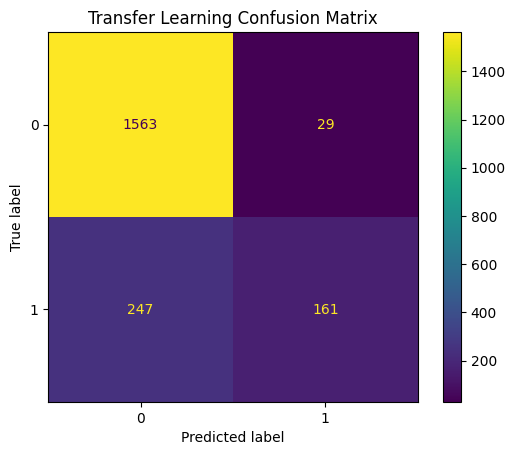

In [24]:
cm = confusion_matrix(yb_test, y_pred_tl)
ConfusionMatrixDisplay(cm).plot()
plt.title("Transfer Learning Confusion Matrix")
plt.show()


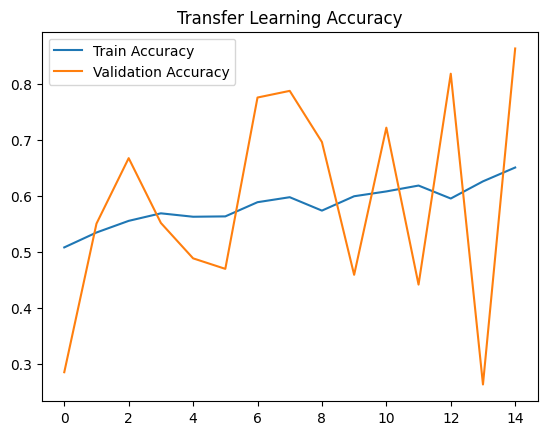

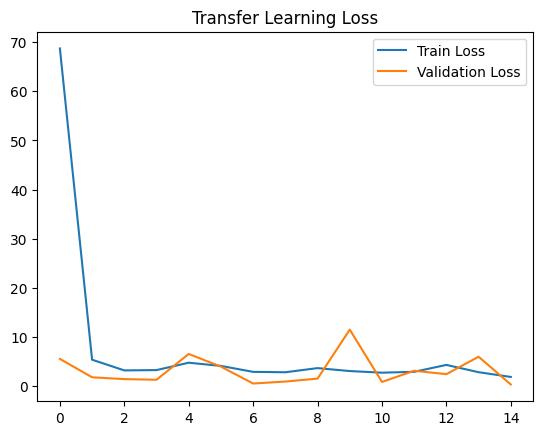

In [25]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Transfer Learning Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Transfer Learning Loss")
plt.legend()
plt.show()


In [26]:
results = pd.DataFrame({
    "Actual": yb_test.values,
    "Predicted_Probability": y_prob_tl.flatten(),
    "Predicted_Class": y_pred_tl.flatten()
})

results.head(10)


,Actual,Predicted_Probability,Predicted_Class
0,0,0.014589,0
1,0,0.060003,0
2,0,0.054546,0
3,1,0.579358,1
4,0,0.091256,0
5,1,0.171543,0
6,1,0.345155,0
7,0,0.041666,0
8,0,0.017923,0
9,0,0.034009,0


In [27]:
# Create results dataframe
results = pd.DataFrame({
    "Actual": yb_test.values,
    "Churn_Probability": y_prob_tl.flatten()
})

# Define risk levels
def risk_category(p):
    if p >= 0.75:
        return "High Risk"
    elif p >= 0.40:
        return "Medium Risk"
    else:
        return "Low Risk"

results["Risk_Level"] = results["Churn_Probability"].apply(risk_category)

results.head()


,Actual,Churn_Probability,Risk_Level
0,0,0.014589,Low Risk
1,0,0.060003,Low Risk
2,0,0.054546,Low Risk
3,1,0.579358,Medium Risk
4,0,0.091256,Low Risk


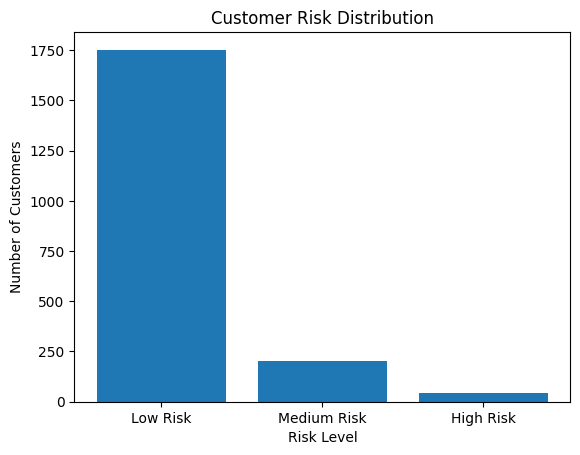

In [28]:
import matplotlib.pyplot as plt

risk_counts = results["Risk_Level"].value_counts()

plt.bar(risk_counts.index, risk_counts.values)
plt.title("Customer Risk Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Number of Customers")
plt.show()


In [29]:
high_risk_customers = results.sort_values(
    by="Churn_Probability", ascending=False
).head(10)

high_risk_customers


,Actual,Churn_Probability,Risk_Level
1042,1,0.998389,High Risk
513,0,0.996720,High Risk
1539,0,0.984308,High Risk
1879,1,0.984051,High Risk
1529,1,0.978335,High Risk
1362,0,0.975127,High Risk
1423,0,0.955919,High Risk
1352,0,0.952124,High Risk
550,0,0.951130,High Risk
1265,0,0.938652,High Risk


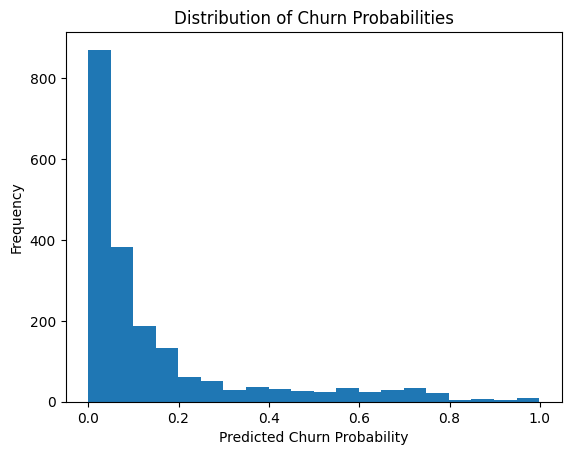

In [30]:
plt.hist(results["Churn_Probability"], bins=20)
plt.title("Distribution of Churn Probabilities")
plt.xlabel("Predicted Churn Probability")
plt.ylabel("Frequency")
plt.show()


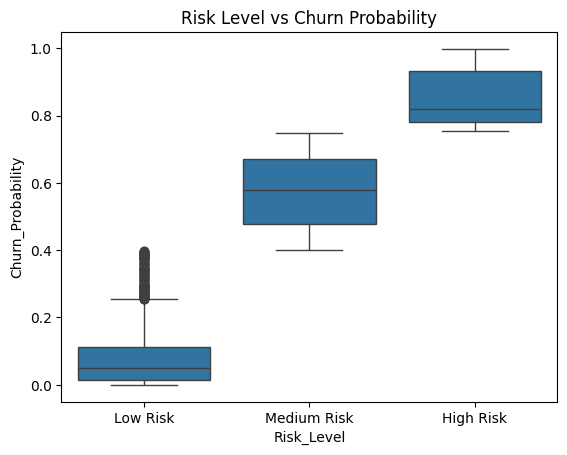

In [31]:
import seaborn as sns

sns.boxplot(x="Risk_Level", y="Churn_Probability", data=results)
plt.title("Risk Level vs Churn Probability")
plt.show()


In [32]:
pip install shap


In [33]:
import shap

# Use a small background sample for speed
explainer = shap.Explainer(transfer_model, Xb_train[:200])

# Compute SHAP values for test set
shap_values = explainer(Xb_test[:200])


ExactExplainer explainer: 201it [00:18, 11.00it/s]                         


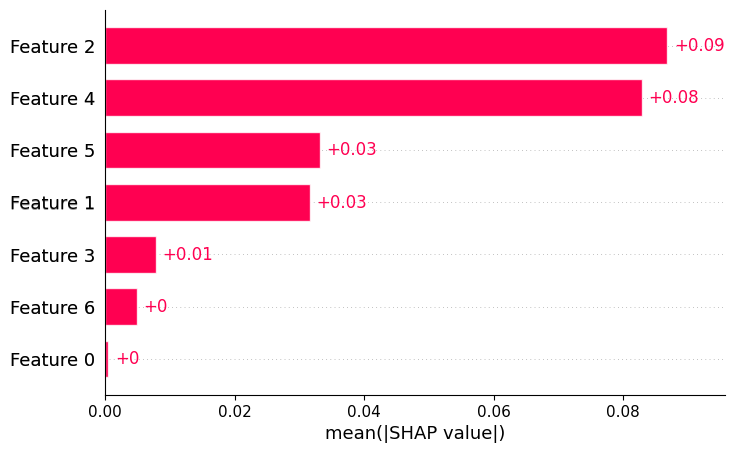

In [34]:
shap.plots.bar(shap_values)


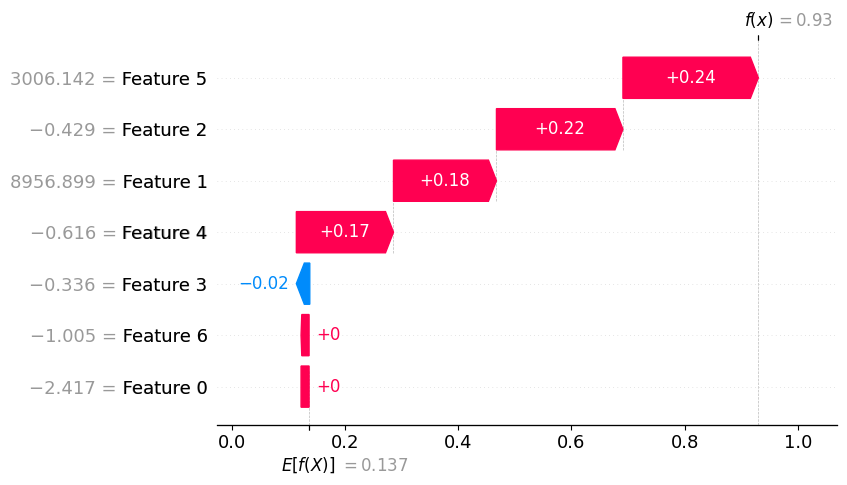

In [36]:
# Only consider first 200 test samples
subset_probs = y_prob_tl[:200]

high_risk_index = np.argmax(subset_probs)

shap.plots.waterfall(shap_values[high_risk_index])


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


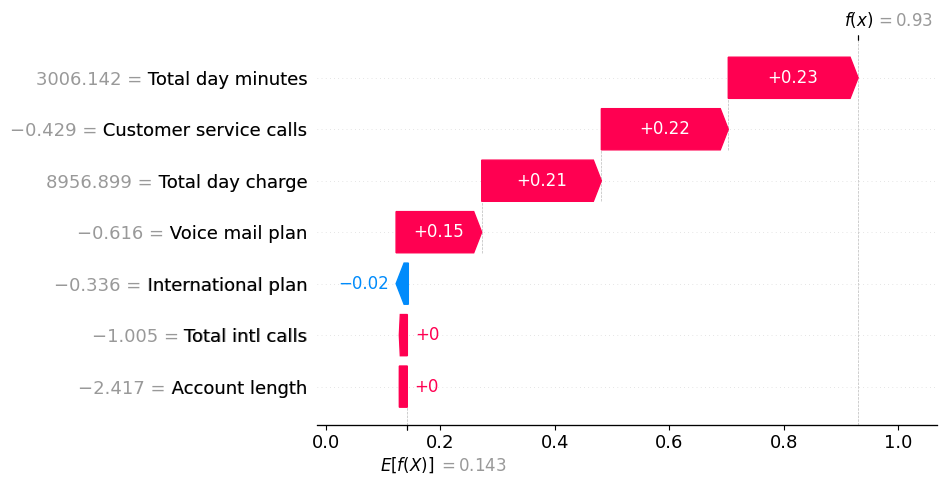

In [38]:
X_subset_df = pd.DataFrame(Xb_test[:200], columns=telecom_features)

explainer = shap.Explainer(transfer_model, X_subset_df)
shap_values = explainer(X_subset_df)

high_risk_index = np.argmax(transfer_model.predict(X_subset_df))
shap.plots.waterfall(shap_values[high_risk_index])
